In [1]:
import numpy as np
import deepcut
from keras.models import Model
from keras.layers import Input, Dense, GRU, LSTM, Dropout, Bidirectional
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# Extract labels and word lists from file.

In [2]:
input_sentence = [i.split("::")[1].replace("\n", '') for i in open("input.txt", encoding="utf8")]
input_ans = [i.split("::")[1].replace("\n", '') for i in open("ans.txt", encoding="utf-8")]

input_zip = list(zip(input_sentence, input_ans))
shuffle(input_zip)

# tokenize all words
words = [[w for w in deepcut.tokenize(s[0]) if w != ' '] for s in input_zip]

In [3]:
# Extracted only the words around "เขา" in total 21 word
def split_from_kau(words):
    q = []
    flag_found_kau = False
    for w in words:
        q.append(w)
        if "เขา" in w:
            flag_found_kau = True
        elif flag_found_kau:
            if len(q) >= 21:
                break
        else:
            if len(q) > 10:
                q.pop(0)
    return q
# print(index_of_kau(words[0]))
words_split = [split_from_kau(w) for w in words]
print(words_split[-10:])
max_sentence_length = 21 # should not be longer than 21

[['ถ้า', 'ไม่', 'มี', 'เขา', 'คง', 'ไม่', 'เท่า', 'ไร', 'ไม่', 'ต้อง', 'ไป', 'ร้อง', 'ไม่', 'ต้อง', 'เสียใจ'], ['ฉัน', 'ล่า', 'สัตว์', 'ใน', 'ป่า', 'เพื่อ', 'เอาเขา'], ['เขา', 'ลูก', 'นั้น', 'ล้อม', 'รอบ', 'ด้วย', 'ป่าไม้'], ['ต่อ', 'ให้', 'เป็น', 'เศษ', 'ดวงใจ', 'เขา', 'เอา', 'ทิ้ง', 'ให้', 'เก็บ'], ['เหี้ย', 'ชอบ', 'เผา', 'ป่า', 'เขา', 'เพื่อ', 'เพาะปลูก'], ['ฉัน', 'คิด', 'ว่า', 'เขา', 'เป็น', 'คน', 'จิตใจ', 'ดี'], ['เขา', 'อัน', 'ใหญ่', 'อัน', 'นั้น', 'น่า', 'ซื้อ', 'จัง'], ['ใหญ่', 'ของ', 'การ', 'สูญ', 'พันธุ์', 'คือ', 'การ', 'ล่า', 'เพิ่ม', 'นำ', 'เขา', 'มา', 'ใช้', 'ประโยชน์'], ['ฉัน', 'ชอบ', 'มอง', 'วิว', 'ที่', 'มี', 'ทิว', 'เขาเขียว', 'ๆ'], ['เขา', 'ทำ', 'ให้', 'ฉัน', 'ปวด', 'หัว']]
21


# Load pretrained word vector (only words in vocab).

In [4]:
vocab = set([w for s in words_split for w in s])

pretrained_word_vec_file = open('cc.th.300.vec', 'r',encoding = 'utf-8-sig')
count = 0
vocab_vec = {}
for line in pretrained_word_vec_file:
    if count > 0:
        line = line.split()
        if(line[0] in vocab): 
            vocab_vec[line[0]] = line[1:]
    count = count + 1


# Create word vectors for all sentences.

In [5]:
# ไม่เจอคำที่มีให้ข้าม
word_vector_length = 300
word_vectors = np.zeros((len(words_split),max_sentence_length,word_vector_length))
sample_count = 0
for s in words_split:
    word_count = 0
    for w in s:
        try:
            word_vectors[sample_count,max_sentence_length-word_count-1,:] = vocab_vec[w]
            word_count = word_count+1
        except:
            pass
    sample_count = sample_count+1

(2384, 21, 300)
[[[ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  ...
  [-0.0036 -0.0562  0.085  ... -0.1096  0.0504  0.0386]
  [ 0.0345 -0.0042  0.0475 ...  0.1224  0.0232  0.0243]
  [-0.0036 -0.0562  0.085  ... -0.1096  0.0504  0.0386]]

 [[ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  [ 0.      0.      0.     ...  0.      0.      0.    ]
  ...
  [-0.0695  0.059   0.1422 ...  0.0509  0.0849  0.054 ]
  [ 0.0228 -0.1414 -0.0217 ...  0.0941 -0.0334  0.0194]
  [ 0.0878 -0.0241  0.0165 ...  0.0623 -0.0989  0.0496]]]


# Create RNN model.

In [54]:
inputLayer = Input(shape=(max_sentence_length,word_vector_length,))
# rnn = GRU(30, activation='relu')(inputLayer)
rnn = Bidirectional(LSTM(30, activation='relu'))(inputLayer)
rnn = Dropout(0.5)(rnn)
outputLayer = Dense(3, activation='softmax')(rnn) # for 3 classes
model = Model(inputs=inputLayer, outputs=outputLayer)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 21, 300)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 60)                79440     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 183       
Total params: 79,623
Trainable params: 79,623
Non-trainable params: 0
_________________________________________________________________
None


# Train RNN Model.

In [55]:
dict_label = {"H":0,"P":1,"M":2}
labels = [dict_label[l[1]] for l in input_zip]
# print(labels)

In [56]:
history = model.fit(word_vectors, to_categorical(labels), epochs=200, batch_size=50, validation_split = 0.1)

Train on 2145 samples, validate on 239 samples
Epoch 1/200
2145/2145 [==============================] - 1s 518us/step - loss: 1.0645 - accuracy: 0.4998 - val_loss: 0.9835 - val_accuracy: 0.7448
Epoch 2/200
2145/2145 [==============================] - 1s 284us/step - loss: 0.8854 - accuracy: 0.6457 - val_loss: 0.7474 - val_accuracy: 0.7657
Epoch 3/200
2145/2145 [==============================] - 1s 281us/step - loss: 0.7063 - accuracy: 0.7394 - val_loss: 0.6155 - val_accuracy: 0.7950
Epoch 4/200
2145/2145 [==============================] - 1s 299us/step - loss: 0.6013 - accuracy: 0.7874 - val_loss: 0.5742 - val_accuracy: 0.8075
Epoch 5/200
2145/2145 [==============================] - 1s 280us/step - loss: 0.5685 - accuracy: 0.8042 - val_loss: 0.5323 - val_accuracy: 0.8033
Epoch 6/200
2145/2145 [==============================] - 1s 280us/step - loss: 0.5044 - accuracy: 0.8177 - val_loss: 0.5253 - val_accuracy: 0.8117
Epoch 7/200
2145/2145 [==============================] - 1s 282us/step 

2145/2145 [==============================] - 1s 276us/step - loss: 0.2519 - accuracy: 0.9133 - val_loss: 0.6391 - val_accuracy: 0.8619
Epoch 57/200
2145/2145 [==============================] - 1s 275us/step - loss: 0.1839 - accuracy: 0.9413 - val_loss: 0.5827 - val_accuracy: 0.8619
Epoch 58/200
2145/2145 [==============================] - 1s 277us/step - loss: 0.1380 - accuracy: 0.9506 - val_loss: 0.6882 - val_accuracy: 0.8661
Epoch 59/200
2145/2145 [==============================] - 1s 273us/step - loss: 0.1145 - accuracy: 0.9543 - val_loss: 0.6828 - val_accuracy: 0.8577
Epoch 60/200
2145/2145 [==============================] - 1s 276us/step - loss: 0.0984 - accuracy: 0.9660 - val_loss: 0.7957 - val_accuracy: 0.8745
Epoch 61/200
2145/2145 [==============================] - 1s 286us/step - loss: 0.0903 - accuracy: 0.9678 - val_loss: 0.7612 - val_accuracy: 0.8661
Epoch 62/200
2145/2145 [==============================] - 1s 278us/step - loss: 0.0889 - accuracy: 0.9641 - val_loss: 1.2154 

2145/2145 [==============================] - 1s 315us/step - loss: 0.0370 - accuracy: 0.9874 - val_loss: 0.9872 - val_accuracy: 0.8619
Epoch 112/200
2145/2145 [==============================] - 1s 313us/step - loss: 0.0285 - accuracy: 0.9893 - val_loss: 1.1407 - val_accuracy: 0.8661
Epoch 113/200
2145/2145 [==============================] - 1s 316us/step - loss: 0.0399 - accuracy: 0.9851 - val_loss: 1.1630 - val_accuracy: 0.8577
Epoch 114/200
2145/2145 [==============================] - 1s 312us/step - loss: 0.0543 - accuracy: 0.9823 - val_loss: 0.7880 - val_accuracy: 0.8577
Epoch 115/200
2145/2145 [==============================] - 1s 317us/step - loss: 0.0384 - accuracy: 0.9874 - val_loss: 0.8850 - val_accuracy: 0.8452
Epoch 116/200
2145/2145 [==============================] - 1s 327us/step - loss: 0.0260 - accuracy: 0.9935 - val_loss: 1.5427 - val_accuracy: 0.8452
Epoch 117/200
2145/2145 [==============================] - 1s 331us/step - loss: 0.0326 - accuracy: 0.9888 - val_loss: 1

2145/2145 [==============================] - 1s 282us/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 1.4579 - val_accuracy: 0.8536
Epoch 167/200
2145/2145 [==============================] - 1s 279us/step - loss: 0.0160 - accuracy: 0.9953 - val_loss: 2.0710 - val_accuracy: 0.8285
Epoch 168/200
2145/2145 [==============================] - 1s 279us/step - loss: 0.0206 - accuracy: 0.9935 - val_loss: 2.3622 - val_accuracy: 0.8285
Epoch 169/200
2145/2145 [==============================] - 1s 279us/step - loss: 0.0189 - accuracy: 0.9935 - val_loss: 1.3283 - val_accuracy: 0.8536
Epoch 170/200
2145/2145 [==============================] - 1s 280us/step - loss: 0.0240 - accuracy: 0.9930 - val_loss: 1.1497 - val_accuracy: 0.8661
Epoch 171/200
2145/2145 [==============================] - 1s 302us/step - loss: 0.0179 - accuracy: 0.9935 - val_loss: 1.5608 - val_accuracy: 0.8577
Epoch 172/200
2145/2145 [==============================] - 1s 282us/step - loss: 0.0185 - accuracy: 0.9930 - val_loss: 1

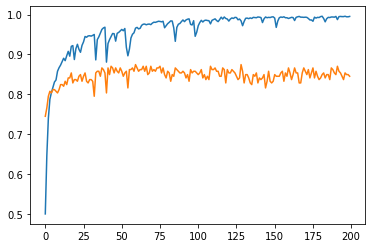

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

# Evaluate with a test set.

In [58]:
# try with every trained set and see accuracy overall
y_pred = model.predict(word_vectors)

cm = confusion_matrix(labels, y_pred.argmax(axis=1))
print('Confusion Matrix')
print(cm)
print((cm[0,0]+cm[1,1]+cm[2,2]) / sum([cm[i,j] for i in range(3) for j in range(3)]))

Confusion Matrix
[[784  14   0]
 [ 11 806   2]
 [  7  11 749]]
0.9811241610738255


In [39]:
model.save("model.h5") # save model for future use